# Вопросно-ответная система по языку Питон

1. batch_size (размер пакета):
   - Значение: Определяет количество образцов, передаваемых через модель за одну итерацию обучения. 
   - Значимость: Большие значения batch_size обеспечивают увеличение скорости обучения, так как модель обрабатывает больше данных одновременно. Однако это также требует большей памяти GPU/памяти CPU. С другой стороны, меньшие значения batch_size могут сделать обучение более стабильным и позволить модели лучше обобщать.
   - Диапазон для экспериментов: Обычно значения batch_size выбираются в диапазоне от 8 до 256.

2. num_epochs (количество эпох):
   - Значение: Определяет, сколько раз полный набор данных будет проходить через модель.
   - Значимость: Большее количество эпох может помочь модели лучше подстроиться под данные и улучшить ее производительность. Однако, если количество эпох слишком велико, то это может привести к переобучению.
   - Диапазон для экспериментов: Обычно количество эпох выбирается в диапазоне от 10 до 100.

3. learning_rate (скорость обучения):
   - Значение: Определяет размер шага, который делает оптимизатор в процессе обновления весов модели.
   - Значимость: Слишком большой learning_rate может привести к тому, что оптимизатор пропустит локальный оптимум, а слишком маленький learning_rate может привести к медленной сходимости или застреванию в локальных оптимумах.
   - Диапазон для экспериментов: Обычно значения learning_rate выбираются в диапазоне от 0.0001 до 0.1.

Эти параметры являются ключевыми для настройки и оптимизации модели, и эксперименты с различными значениями этих параметров могут значительно повлиять на производительность модели.

In [1]:
import torch
print("Is CUDA enabled?",torch.cuda.is_available())

# Задание параметров:
number_of_files = 4 # количество используемых файлов на обучение (нумирация с 0)
batch_size = 200
num_epochs = 30
learning_rate = 1e-4

# Если на запускаемом устройстве есть cuda, то берем её для работы на GPU, в противном случае вычисления только на CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Is CUDA enabled? False


### Чтение подготовленных данных:

Через `handler_json_chunk.py` мы получили готовые файлы вопросов: questions_0.json, questions_1.json, ...

Со структурой файла:
```(json)
{
    "questions": [
        {
            "value": "..."
        },
        ...
    ]
}
```
И ответов: answers_0.json, answers_1.json, ...

Со структурой файла:
```(json)
{
    "answers": [
        {
            "value": "..."
        },
        ...
    ]
}
```

Теперь приводим эти данные в вид list-ов: questions_train, questions_val, answers_train, answers_val.

Где каждый i-й элемент получен из i-го файла.


In [2]:
import ijson
import os
from setuptools import setup
from sklearn.model_selection import train_test_split

def parse_large_json(file_path):
    # Открытие файла для потоковой обработки
    answ_list = []

    with open(file_path, 'rb') as file:
        # Потоковая обработка элементов JSON
        parser = ijson.parse(file)

        for prefix, event, value in parser:
            # тут нас интересуют элементы списков в json и событие по нахождению какого-либо ключа в этом списке
            if prefix.endswith('.item') and event == 'map_key':
                # заготовка под объект json, который будем строить
                json_object = {}
                # пока в текущем списке есть элементы, будем их анализировать

                while event == 'map_key':
                    # ijson идет итеративно по ключам и значениям
                    # поэтому сначала сохраняем уже полученный ключ,
                    # а потом запускаем следующую итерацию для получения значения
                    key = value
                    _, _, value = next(parser)
                    
                    answ_list.append(value)
                    json_object[key] = value
                    # для продолжения нашего while нам нужно снова перейти на следующий ключ списка
                    # поэтому в этой итерации мы специально сеттим event (там как раз будет map_key)
                    prefix, event, value = next(parser)

                # с построенным объектом json можем делать что угодно, тут мы сверяем его с фильтром и записываем

    return answ_list

# full_dir - полный путь до json файлов
full_dir = os.path.dirname(os.path.realpath('__file__'))

questions_train = []
questions_val = []
answers_train = []
answers_val = []

for i in range(number_of_files):
    current_answers = parse_large_json(full_dir + '/handler_json_chunk/answers_' + str(i) + '.json')
    current_questions = parse_large_json(full_dir + '/handler_json_chunk/questions_' + str(i) + '.json')

    current_questions_train, current_questions_val, current_answers_train, current_answers_val = train_test_split(
            current_questions, current_answers, test_size=0.2, random_state=42
        )
    questions_train.append(current_questions_train)
    questions_val.append(current_questions_val)
    answers_train.append(current_answers_train)
    answers_val.append(current_answers_val)

# Создаем список меток, 0 или 1, в зависимости от того, насколько хорошо ответ соответствует вопросу
labels_list = [1] * (len(questions_train[0]) + len(questions_val[0]))
# По умолчанию считаем, что все ответы соответствуют вопросу

print('Количество вопросов на обучение в каждом из ', number_of_files + 1,' файлов: ', len(questions_train[0]))
print('Количество ответов на обучение в каждом из ', number_of_files + 1,' файлов: ', len(answers_train[0]))

print('Количество вопросов на валидацию в каждом из ', number_of_files + 1,' файлов: ', len(questions_val[0]))
print('Количество ответов на валидацию в каждом из ', number_of_files + 1,' файлов: ', len(answers_val[0]))

Количество вопросов на обучение в каждом из  5  файлов:  64
Количество ответов на обучение в каждом из  5  файлов:  64
Количество вопросов на валидацию в каждом из  5  файлов:  16
Количество ответов на валидацию в каждом из  5  файлов:  16


### Реализация классов QADataset и BertClassifier:

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from sklearn.metrics import accuracy_score

class QADataset(torch.utils.data.Dataset):
    def __init__(self, questions, answers, tokenizer, labels=None, max_length=512):
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    # Этот метод возвращает количество элементов в наборе данных. Он используется при создании объекта DataLoader для определения числа итераций в каждой эпохе обучения.
    def __len__(self):
        return len(self.questions)

    # Этот метод возвращает элемент данных по указанному индексу idx. Он используется для доступа к конкретному образцу данных из набора данных по его индексу. Обычно возвращает словарь или кортеж, содержащий признаки и целевую переменную (если есть).
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.questions[idx],
            self.answers[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])

        return item

# Определение модели
class BertClassifier(nn.Module):
    def __init__(self):
        # Вызов конструктора родительского класса BertClassifier, который позволяет наследовать функциональность родительского класса nn.Module. В данном случае, он инициализирует наследуемые атрибуты и методы, которые используются в классе BertClassifier:
        super(BertClassifier, self).__init__()
        
        # Экземпляр модели BERT, который используется внутри класса BertClassifier. Он загружает предобученную модель BERT, которая уже содержит веса и архитектуру, обученные на большом объеме текстовых данных.
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        
        # Слой Dropout, который применяется к логитам после прохождения через модель BERT. Dropout помогает предотвратить переобучение, выключая случайно выбранные нейроны во время обучения.
        self.dropout = nn.Dropout(0.1)  
        
        # Линейный слой, который применяется к логитам после применения Dropout. Он преобразует выходы модели BERT в оценки для каждого класса задачи классификации.
        self.classifier = nn.Linear(self.bert.config.num_labels, 2)

    # Этот метод определяет проход данных через модель. В данном случае, метод forward принимает на вход input_ids (идентификаторы токенов) и attention_mask (маску внимания), передает их в модель BERT и затем выполняет последовательность операций для получения предсказаний (логитов). Возвращаемые значения - это логиты, которые представляют собой оценки для каждого класса.
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = self.dropout(logits)
        logits = self.classifier(logits)
        return logits

### Инициализация модели, токенизатора и оптимизатора:

1) Уменьшение скорости обучения (Learning Rate Decay):
   - Для чего используется: Уменьшение скорости обучения позволяет стабилизировать процесс обучения модели, делая шаги обучения более маленькими по мере приближения к оптимуму. Это помогает предотвратить "перескакивание" оптимальной точки и повысить сходимость модели.
   - Как работает: Когда модель находится в пространстве потерь (loss space), она пытается найти минимум функции потерь. Уменьшение скорости обучения позволяет уменьшить величину шага в направлении, противоположном градиенту функции потерь, уменьшая тем самым вероятность "перескакивания" через оптимальную точку.

2) L2-регуляризация (Weight Decay):
   - Для чего используется: L2-регуляризация помогает предотвратить переобучение модели, штрафуя большие значения весовых коэффициентов модели. Это достигается путем добавления к функции потерь дополнительного слагаемого, пропорционального квадрату значений весовых коэффициентов.
   - Как работает: В процессе обновления весов модели во время обучения добавляется дополнительное слагаемое, вычитающее некоторую долю весов (пропорциональную значению `weight_decay`) из градиента функции потерь. Это приводит к постепенному уменьшению значений весов и предотвращает их чрезмерное увеличение.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Инициализация модели, токенизатора и оптимизатора
model = BertClassifier().to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Уменьшение скорости обучения
optimizer = AdamW(model.parameters(), lr=1e-5)
# Добавление L2-регуляризации
weight_decay = 0.01
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=weight_decay)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies = [], [], [], [] # инициализация списков для хранения метрик

### Функция для обучения модели:

1) Обработка данных из `train_dataloader`:
   - train_dataloader возвращает батчи данных из обучающего набора. Каждый батч содержит несколько примеров данных.
   - `input_ids` и `attention_mask`: Это тензоры, содержащие идентификаторы токенов и маски внимания, соответственно. Они представляют собой входные данные для модели BERT.
   - `labels`: Это тензор, содержащий целевые метки для задачи классификации. Он используется для вычисления функции потерь и обновления параметров модели.

2) CrossEntropyLoss:
   - Что делает: Функция потерь CrossEntropyLoss используется для задач классификации и измеряет расхождение между предсказаниями модели и истинными метками. Она вычисляет кросс-энтропию между предсказанным распределением вероятностей и истинными метками.
   - Какая польза: CrossEntropyLoss штрафует модель за неверные предсказания, стимулируя ее к более точным выводам. При минимизации этой функции потерь модель старается уменьшить расхождение между предсказаниями и истинными метками, что приводит к улучшению качества модели.

In [6]:
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_predictions = []
        train_targets = []

        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_predictions.extend(torch.argmax(outputs, axis=1).tolist())
            train_targets.extend(labels.tolist())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = sum(train_losses) / len(train_losses)

        model.eval()
        val_losses = []
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                val_losses.append(loss.item())
                val_predictions.extend(torch.argmax(outputs, axis=1).tolist())
                val_targets.extend(labels.tolist())

        val_accuracy = accuracy_score(val_targets, val_predictions)
        avg_val_loss = sum(val_losses) / len(val_losses)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        total_train_losses.append(avg_train_loss)
        total_val_losses.append(avg_val_loss)
        total_train_accuracies.append(train_accuracy)
        total_val_accuracies.append(val_accuracy)

### Построение графиков потерь и точности:

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# train_losses = []  # Список для хранения значений потерь на обучающем наборе
# val_losses = []  # Список для хранения значений потерь на валидационном наборе
# train_accuracies = []  # Список для хранения значений точности на обучающем наборе
# val_accuracies = []  # Список для хранения значений точности на валидационном наборе

def drawing_graphs(numb_stage):

    for epoch in range(num_epochs):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))

        # График потерь
        plt.subplot(1, 2, 1)
        plt.plot(total_train_losses, label='Training Loss')
        plt.plot(total_val_losses, label='Validation Loss')
        plt.title('Epoch: {}/{}, Stage number: {}'.format(epoch + 1, num_epochs, numb_stage))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # График точности
        plt.subplot(1, 2, 2)
        plt.plot(total_train_accuracies, label='Training Accuracy')
        plt.plot(total_val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

### Запускаем обучение для первого входного файла:

In [8]:
# Для первого файла:
train_dataset = QADataset(questions_train[0], answers_train[0], tokenizer, labels_list)
val_dataset = QADataset(questions_val[0], answers_val[0], tokenizer, labels_list)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Обучение модели:
train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs)

Epoch 1/30, Train Loss: 0.7819, Train Accuracy: 0.0000, Validation Loss: 0.7635, Validation Accuracy: 0.0000
Epoch 2/30, Train Loss: 0.7515, Train Accuracy: 0.0000, Validation Loss: 0.7190, Validation Accuracy: 0.0000
Epoch 3/30, Train Loss: 0.7160, Train Accuracy: 0.1094, Validation Loss: 0.6775, Validation Accuracy: 1.0000
Epoch 4/30, Train Loss: 0.6824, Train Accuracy: 0.6875, Validation Loss: 0.6543, Validation Accuracy: 1.0000
Epoch 5/30, Train Loss: 0.6627, Train Accuracy: 0.8906, Validation Loss: 0.6407, Validation Accuracy: 1.0000
Epoch 6/30, Train Loss: 0.6526, Train Accuracy: 0.9062, Validation Loss: 0.6300, Validation Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.6364, Train Accuracy: 0.9375, Validation Loss: 0.6229, Validation Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.6250, Train Accuracy: 0.9844, Validation Loss: 0.6160, Validation Accuracy: 1.0000
Epoch 9/30, Train Loss: 0.6210, Train Accuracy: 0.9688, Validation Loss: 0.6082, Validation Accuracy: 1.0000
Epoch 10/30, Train 

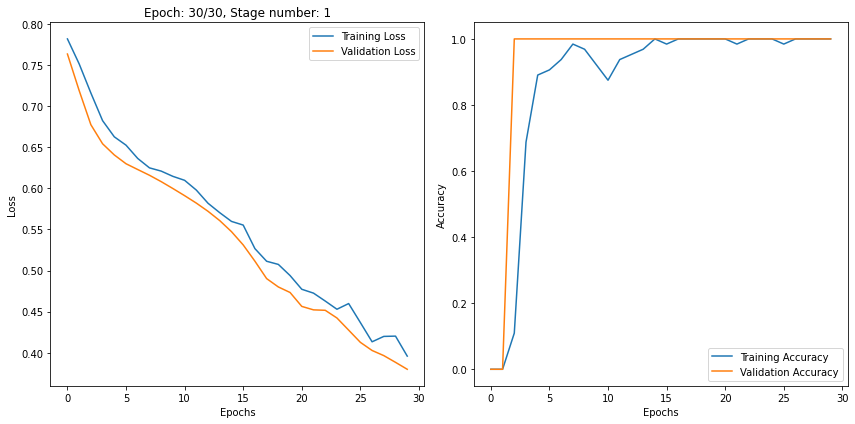

In [9]:
# Строим графики:
drawing_graphs(1)

# Очищение данных:
total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies = [], [], [], []

### Запускаем обучение для второго входного файла:

In [10]:
# Для второго файла:
train_dataset = QADataset(questions_train[1], answers_train[1], tokenizer, labels_list)
val_dataset = QADataset(questions_val[1], answers_val[1], tokenizer, labels_list)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Обучение модели:
train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs)

Epoch 1/30, Train Loss: 0.3926, Train Accuracy: 1.0000, Validation Loss: 0.3781, Validation Accuracy: 1.0000
Epoch 2/30, Train Loss: 0.4104, Train Accuracy: 1.0000, Validation Loss: 0.3734, Validation Accuracy: 1.0000
Epoch 3/30, Train Loss: 0.3976, Train Accuracy: 0.9844, Validation Loss: 0.3681, Validation Accuracy: 1.0000
Epoch 4/30, Train Loss: 0.3736, Train Accuracy: 0.9688, Validation Loss: 0.3606, Validation Accuracy: 1.0000
Epoch 5/30, Train Loss: 0.3719, Train Accuracy: 0.9688, Validation Loss: 0.3516, Validation Accuracy: 1.0000
Epoch 6/30, Train Loss: 0.3572, Train Accuracy: 0.9844, Validation Loss: 0.3435, Validation Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.3548, Train Accuracy: 1.0000, Validation Loss: 0.3370, Validation Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.3471, Train Accuracy: 1.0000, Validation Loss: 0.3310, Validation Accuracy: 1.0000
Epoch 9/30, Train Loss: 0.3436, Train Accuracy: 0.9844, Validation Loss: 0.3249, Validation Accuracy: 1.0000
Epoch 10/30, Train 

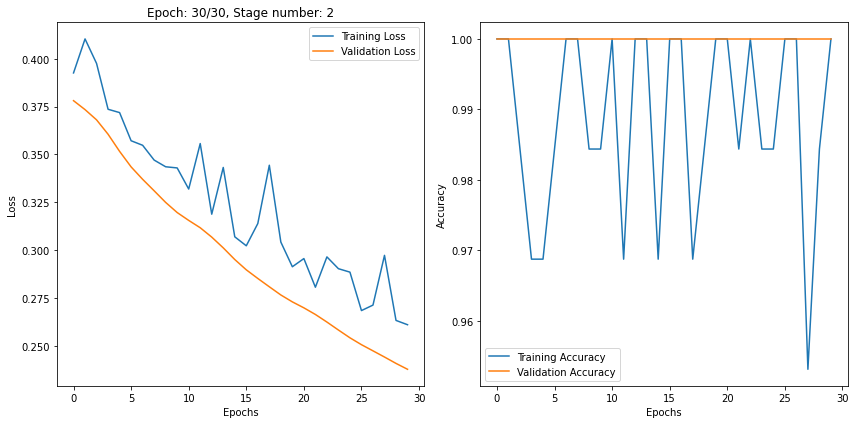

In [11]:
# Строим графики:
drawing_graphs(2)

# Очищение данных:
total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies = [], [], [], []

### Запускаем обучение для третьего входного файла:

In [12]:
# Для третьего файла:
train_dataset = QADataset(questions_train[2], answers_train[2], tokenizer, labels_list)
val_dataset = QADataset(questions_val[2], answers_val[2], tokenizer, labels_list)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Обучение модели:
train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs)

Epoch 1/30, Train Loss: 0.2517, Train Accuracy: 1.0000, Validation Loss: 0.2354, Validation Accuracy: 1.0000
Epoch 2/30, Train Loss: 0.2651, Train Accuracy: 0.9688, Validation Loss: 0.2327, Validation Accuracy: 1.0000
Epoch 3/30, Train Loss: 0.2516, Train Accuracy: 0.9844, Validation Loss: 0.2299, Validation Accuracy: 1.0000
Epoch 4/30, Train Loss: 0.2558, Train Accuracy: 1.0000, Validation Loss: 0.2269, Validation Accuracy: 1.0000
Epoch 5/30, Train Loss: 0.2276, Train Accuracy: 1.0000, Validation Loss: 0.2240, Validation Accuracy: 1.0000
Epoch 6/30, Train Loss: 0.2440, Train Accuracy: 0.9844, Validation Loss: 0.2212, Validation Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.2442, Train Accuracy: 0.9844, Validation Loss: 0.2184, Validation Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.2489, Train Accuracy: 0.9844, Validation Loss: 0.2158, Validation Accuracy: 1.0000
Epoch 9/30, Train Loss: 0.2478, Train Accuracy: 0.9844, Validation Loss: 0.2134, Validation Accuracy: 1.0000
Epoch 10/30, Train 

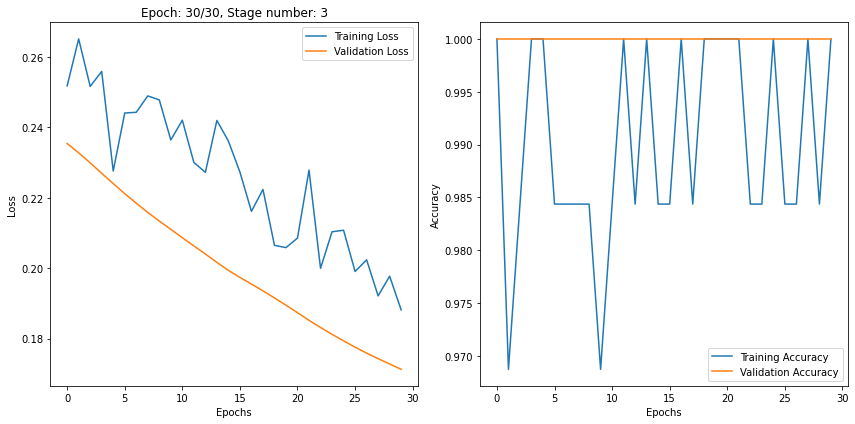

In [13]:
# Строим графики:
drawing_graphs(3)

# Очищение данных:
total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies = [], [], [], []

### Запускаем обучение для четвертого входного файла:

In [14]:
# Для четвертого файла:
train_dataset = QADataset(questions_train[3], answers_train[3], tokenizer, labels_list)
val_dataset = QADataset(questions_val[3], answers_val[3], tokenizer, labels_list)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Обучение модели:
train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs)

Epoch 1/30, Train Loss: 0.1973, Train Accuracy: 0.9844, Validation Loss: 0.1700, Validation Accuracy: 1.0000
Epoch 2/30, Train Loss: 0.2050, Train Accuracy: 0.9844, Validation Loss: 0.1682, Validation Accuracy: 1.0000
Epoch 3/30, Train Loss: 0.2110, Train Accuracy: 0.9688, Validation Loss: 0.1664, Validation Accuracy: 1.0000
Epoch 4/30, Train Loss: 0.1953, Train Accuracy: 1.0000, Validation Loss: 0.1648, Validation Accuracy: 1.0000
Epoch 5/30, Train Loss: 0.1733, Train Accuracy: 1.0000, Validation Loss: 0.1632, Validation Accuracy: 1.0000
Epoch 6/30, Train Loss: 0.2116, Train Accuracy: 0.9844, Validation Loss: 0.1618, Validation Accuracy: 1.0000
Epoch 7/30, Train Loss: 0.1776, Train Accuracy: 0.9844, Validation Loss: 0.1603, Validation Accuracy: 1.0000
Epoch 8/30, Train Loss: 0.1755, Train Accuracy: 1.0000, Validation Loss: 0.1589, Validation Accuracy: 1.0000
Epoch 9/30, Train Loss: 0.1807, Train Accuracy: 0.9844, Validation Loss: 0.1574, Validation Accuracy: 1.0000
Epoch 10/30, Train 

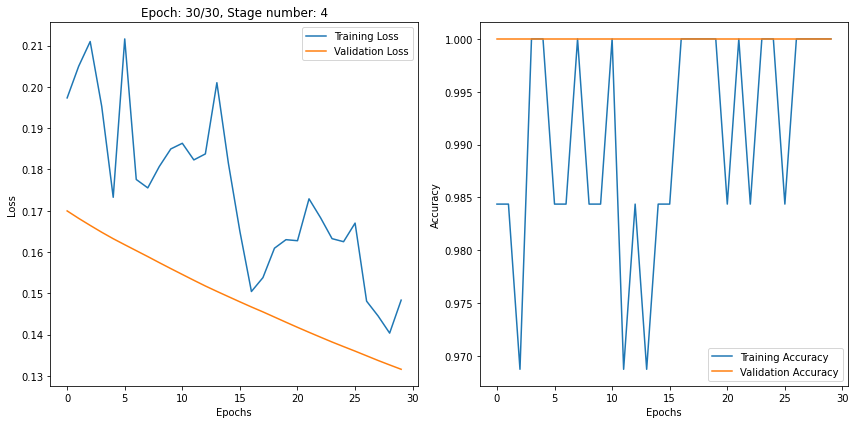

In [15]:
# Строим графики:
drawing_graphs(4)

# Очищение данных:
total_train_losses, total_val_losses, total_train_accuracies, total_val_accuracies = [], [], [], []